In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Styling
plt.style.use('tdrstyle.mplstyle')

In [2]:
from rootpy.io import root_open
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.10/09


In [3]:
infile_r = None  # input file handle

def load_pgun():
  global infile_r
  infile = '../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root'
  #if use_condor:
  #  infile = 'root://cmsio5.rc.ufl.edu//store/user/jiafulow/L1MuonTrigger/P2_10_1_5/SingleMuon_Toy_2GeV/'+infile
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  #tree = TreeChain('ntupler/tree', [infile])
  print('[INFO] Opening file: %s' % infile)

  # Define collection
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  return tree

In [4]:
#maxEvents = 4000000
maxEvents = 500000
#maxEvents = 10000

kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

eta_bins = (1.2, 1.55, 1.7, 1.8, 1.98, 2.15, 2.4)
eta_bins = eta_bins[::-1]
pt_bins = (-0.5 , -0.38, -0.26, -0.15, -0.05, 0.05, 0.15, 0.26, 0.38, 0.5)
nlayers = 12  # 5 (CSC) + 4 (RPC) + 3 (GEM)
superstrip_size = 32

assert(len(eta_bins) == 6+1)
assert(len(pt_bins) == 9+1)

from six.moves import range, zip, map, filter

from incrementalstats import IncrementalStats

def find_sector(phi):  # phi in radians
  dphi = delta_phi(phi, np.pi/12)  # sector 1 starts at 15 deg
  dphi = int(np.floor(dphi/(np.pi/3)))  # divide by 60 deg
  if dphi < 0:
    sector = 7 + dphi
  else:
    sector = 1 + dphi
  return sector

def find_endcap(eta):
  endcap = +1 if eta >= 0. else -1
  return endcap

def find_endsec(endcap, sector):
  endsec = (sector - 1) if endcap == 1 else (sector - 1 + 6)
  return endsec

def find_pt_bin(pt):
  ipt = np.digitize((pt,), pt_bins[1:])[0]  # skip lowest edge
  ipt = np.clip(ipt, 0, len(pt_bins)-2)
  return ipt

def find_eta_bin(eta):
  ieta = np.digitize((abs(eta),), eta_bins[1:])[0]  # skip lowest edge
  ieta = np.clip(ieta, 0, len(eta_bins)-2)
  return ieta

def _find_bin_fast(x, bins):
  x = np.clip(x, bins[1], bins[2]-1e-8)
  binx = (x - bins[1]) / (bins[2] - bins[1]) * bins[0]
  return int(binx)

def find_eta_bin_13(eta, bins=(13,1.2,2.5)):
  return _find_bin_fast(abs(eta), bins)

def find_pt_bin_50(pt, bins=(50,-0.5,0.5)):
  return _find_bin_fast(pt, bins)

# Decide EMTF hit layer number
class EMTFLayer(object):
  def __init__(self):
    lut = np.zeros((5,5,5), dtype=np.int32) - 99  # (type, station, ring) -> layer
    lut[1,1,4] = 0  # ME1/1a
    lut[1,1,1] = 0  # ME1/1b
    lut[1,1,2] = 1  # ME1/2
    lut[1,1,3] = 1  # ME1/3
    lut[1,2,1] = 2  # ME2/1
    lut[1,2,2] = 2  # ME2/2
    lut[1,3,1] = 3  # ME3/1
    lut[1,3,2] = 3  # ME3/2
    lut[1,4,1] = 4  # ME4/1
    lut[1,4,2] = 4  # ME4/2
    lut[2,1,2] = 5  # RE1/2
    lut[2,2,2] = 6  # RE2/2
    lut[2,3,1] = 7  # RE3/1
    lut[2,3,2] = 7  # RE3/2
    lut[2,3,3] = 7  # RE3/3
    lut[2,4,1] = 8  # RE4/1
    lut[2,4,2] = 8  # RE4/2
    lut[2,4,3] = 8  # RE4/3
    lut[3,1,1] = 9  # GE1/1
    lut[3,2,1] = 10 # GE2/1
    lut[4,1,1] = 11 # ME0
    self.lut = lut

  def __call__(self, hit):
    index = (hit.type, hit.station, hit.ring)
    entry = self.lut[index]
    return entry

find_emtf_layer = EMTFLayer()

# Decide EMTF hit zones
class EMTFZone(object):
  def __init__(self):
    lut = np.zeros((5,5,5,6,2), dtype=np.int32) - 99  # (type, station, ring) -> [zone] x [min_theta,max_theta]
    lut[1,1,4][0] = 4,17   # ME1/1a
    lut[1,1,4][1] = 16,26  # ME1/1a
    lut[1,1,4][2] = 24,37  # ME1/1a
    lut[1,1,4][3] = 34,43  # ME1/1a
    lut[1,1,4][4] = 40,53  # ME1/1a
    lut[1,1,1][0] = 4,17   # ME1/1b
    lut[1,1,1][1] = 16,26  # ME1/1b
    lut[1,1,1][2] = 24,37  # ME1/1b
    lut[1,1,1][3] = 34,43  # ME1/1b
    lut[1,1,1][4] = 40,53  # ME1/1b
    lut[1,1,2][4] = 46,54  # ME1/2
    lut[1,1,2][5] = 52,88  # ME1/2
    lut[1,1,3][4] = 46,54  # ME1/3
    lut[1,1,3][5] = 52,88  # ME1/3
    #
    lut[1,2,1][0] = 4,17   # ME2/1
    lut[1,2,1][1] = 16,25  # ME2/1
    lut[1,2,1][2] = 24,36  # ME2/1
    lut[1,2,1][3] = 34,43  # ME2/1
    lut[1,2,1][4] = 40,49  # ME2/1
    lut[1,2,2][5] = 53,88  # ME2/2
    #
    lut[1,3,1][0] = 4,17   # ME3/1
    lut[1,3,1][1] = 16,25  # ME3/1
    lut[1,3,1][2] = 24,36  # ME3/1
    lut[1,3,1][3] = 34,40  # ME3/1
    lut[1,3,2][4] = 44,54  # ME3/2
    lut[1,3,2][5] = 52,88  # ME3/2
    #
    lut[1,4,1][0] = 4,17   # ME4/1
    lut[1,4,1][1] = 16,25  # ME4/1
    lut[1,4,1][2] = 24,35  # ME4/1
    lut[1,4,2][3] = 38,43  # ME4/2
    lut[1,4,2][4] = 41,54  # ME4/2
    lut[1,4,2][5] = 52,88  # ME4/2
    #
    lut[2,1,2][5] = 52,84  # RE1/2
    lut[2,2,2][5] = 56,76  # RE2/2
    lut[2,3,1][0] = 4,20   # RE3/1
    lut[2,3,1][1] = 20,24  # RE3/1
    lut[2,3,1][2] = 24,32  # RE3/1
    lut[2,3,2][3] = 40,40  # RE3/2
    lut[2,3,2][4] = 40,52  # RE3/2
    lut[2,3,2][5] = 48,84  # RE3/2
    lut[2,3,3][3] = 40,40  # RE3/3
    lut[2,3,3][4] = 40,52  # RE3/3
    lut[2,3,3][5] = 48,84  # RE3/3
    lut[2,4,1][0] = 8,16   # RE4/1
    lut[2,4,1][1] = 16,28  # RE4/1
    lut[2,4,1][2] = 24,28  # RE4/1
    lut[2,4,2][3] = 36,44  # RE4/2
    lut[2,4,2][4] = 44,52  # RE4/2
    lut[2,4,2][5] = 52,84  # RE4/2
    lut[2,4,3][3] = 36,44  # RE4/3
    lut[2,4,3][4] = 44,52  # RE4/3
    lut[2,4,3][5] = 52,84  # RE4/3
    #
    lut[3,1,1][1] = 17,26  # GE1/1
    lut[3,1,1][2] = 24,37  # GE1/1
    lut[3,1,1][3] = 35,45  # GE1/1
    lut[3,1,1][4] = 40,52  # GE1/1
    lut[3,2,1][0] = 7,19   # GE2/1
    lut[3,2,1][1] = 18,24  # GE2/1
    lut[3,2,1][2] = 23,35  # GE2/1
    lut[3,2,1][3] = 34,45  # GE2/1
    lut[3,2,1][4] = 40,46  # GE2/1
    #
    lut[4,1,1][0] = 4,17   # ME0
    lut[4,1,1][1] = 16,23  # ME0
    self.lut = lut
    
  def __call__(self, hit):
    index = (hit.type, hit.station, hit.ring)
    entry = self.lut[index]
    answer = (entry[:,0] <= hit.emtf_theta) & (hit.emtf_theta <= entry[:,1])
    zones = np.nonzero(answer)
    if isinstance(zones, tuple):
      zones = zones[0]
    return zones

find_emtf_zones = EMTFZone()

# Decide EMTF hit bend
class EMTFBend(object):
  def __init__(self):
    self.lut = np.array([5, -5, 4, -4, 3, -3, 2, -2, 1, -1, 0], dtype=np.int32)

  def __call__(self, hit):
    if hit.type == kCSC:
      #clct = int(hit.pattern)
      #bend = self.lut[clct]
      bend = hit.bend
      bend *= hit.endcap
    elif hit.type == kGEM:
      bend = hit.bend
      bend *= hit.endcap
    else:  # kRPC, kME0
      bend = hit.bend
    return bend

find_emtf_bend = EMTFBend()

class EMTFZee(object):
  def __init__(self):
    self.lut = np.array([599.0, 696.8, 827.1, 937.5, 1027, 708.7, 790.9, 968.8, 1060, 566.4, 794.8, 539.3], dtype=np.float32)
    assert(self.lut.shape[0] == nlayers)
  
  def __call__(self, hit):
    return self.lut[hit.emtf_layer]

find_emtf_zee = EMTFZee()

class EMTFPhi(object):
  def __init__(self):
    pass
  
  def __call__(self, hit):
    if hit.type == kCSC:
      if hit.station == 1:
        if hit.ring == 1:
          bend_corr_lut = (-1.3861, 1.3692)  # ME1/1b (r,f)
        elif hit.ring == 4:
          bend_corr_lut = (-1.6419, 1.6012)  # ME1/1a (r,f)
        else:
          bend_corr_lut = (-0.9237, 0.8287)  # ME1/2 (r,f)
        bend_corr = bend_corr_lut[int(hit.fr)] * hit.bend
        bend_corr = bend_corr if hit.endcap == 1 else (bend_corr * -1)
        bend_corr = int(round(bend_corr))
        return hit.emtf_phi + bend_corr
      else:
        pass
    else:
      pass
    return hit.emtf_phi

find_emtf_phi = EMTFPhi()

class EMTFLayerPartner(object):
  def __init__(self):
    self.lut = np.array([2, 2, 0, 0, 0, 0, 2, 3, 4, 0, 2, 0], dtype=np.int32)
    assert(self.lut.shape[0] == nlayers)

  def __call__(self, emtf_layer, zone):
    partner = self.lut[emtf_layer]
    if zone >= 5:  # zones 5,6, use ME1/2
      if partner == 0:
        partner = 1
    return partner

find_emtf_layer_partner = EMTFLayerPartner()

# Decide EMTF road mode
def is_emtf_singlemu(mode):
  return mode in (11,13,14,15)

def is_emtf_doublemu(mode):
  return mode in (7,10,12) + (11,13,14,15)

def is_emtf_muopen(mode):
  return mode in (3,5,6,9) + (7,10,12) + (11,13,14,15)

# Decide EMTF legit hit
def is_emtf_legit_hit(hit):
  def check_bx(hit):
    if hit.type == kCSC:
      return hit.bx in (-1,0)
    else:
      return hit.bx == 0
  #
  def check_quality(hit):
    if hit.type == kRPC:
      return hit.quality <= 9  # cluster width
    else:
      return True
  #
  return check_bx(hit) and check_quality(hit)

In [5]:
# Main analysis

def analysis(verbose=1):
  tree = load_pgun()
  
  out_part, out_hits = [], []
  
  # Loop over events
  for ievt, evt in enumerate(tree):
    if maxEvents != -1 and ievt == maxEvents:
      break
    
    if verbose and (ievt % 10000 == 0):  print("Processing event: {0}".format(ievt))
    
    # Skip events with very few hits
    if not len(evt.hits) >= 4:
      continue
    
    # Skip events without ME1 hits
    has_ME1 = False
    for ihit, hit in enumerate(evt.hits):
      if hit.type == kCSC and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kME0 and hit.station == 1:
        has_ME1 = True
        break
    if not has_ME1:
      continue
    
    part = evt.particles[0]  # particle gun
    part.invpt = np.true_divide(part.q, part.pt)
    
    # Find the best sector (using csc-only 'mode')
    sector_mode_array = np.zeros((12,), dtype=np.int32)
    sector_hits_array = np.empty((12,), dtype=np.object)
    for ind in np.ndindex(sector_hits_array.shape):
      sector_hits_array[ind] = []
      
    legit_hits = filter(is_emtf_legit_hit, evt.hits)
    
    for ihit, hit in enumerate(legit_hits):
      assert(hit.emtf_phi < 5040)  # 84*60
      
      if hit.sim_tp1 == 0 and hit.sim_tp2 == 0:
        endsec = find_endsec(hit.endcap, hit.sector)
        if hit.type == kCSC:
          sector_mode_array[endsec] |= (1 << (4 - hit.station))
        elif hit.type == kME0:
          sector_mode_array[endsec] |= (1 << (4 - hit.station))
        sector_hits_array[endsec].append(hit)
    
    # Get the best sector
    best_sector = np.argmax(sector_mode_array)
    mode = sector_mode_array[best_sector]
    
    # Skip events without SingleMu modes
    if not is_emtf_singlemu(mode):
      continue
    
    # Get the particle info, road info
    ipt = find_pt_bin(part.invpt)
    ieta = find_eta_bin(part.eta)
    ipt50 = find_pt_bin_50(part.invpt)
    ieta13 = find_eta_bin_13(part.eta)
    
    # Get the hits
    sector_hits = sector_hits_array[best_sector]
    
    amap = {}  # zone -> hits
    
    # Loop over sector hits
    for ihit, hit in enumerate(sector_hits):
      hit.emtf_layer = find_emtf_layer(hit)
      assert(hit.emtf_layer != -99)
      
      hit.old_emtf_phi = hit.emtf_phi
      hit.emtf_zee = find_emtf_zee(hit)
      hit.emtf_phi = find_emtf_phi(hit)
      
      zones = find_emtf_zones(hit)
      for z in zones:
        amap.setdefault(np.asscalar(z), []).append(hit)
      continue  # end loop over sector_hits
    
    # Loop over map of zone -> hits
    ievt_part = []
    ievt_hits = []
    
    for k, v in amap.iteritems():
      zone = k
      hits = v
      
      mode = 0  # csc-only 'mode'
      for ihit, hit in enumerate(hits):
        if hit.type == kCSC:
          mode |= (1 << (4 - hit.station))
        elif hit.type == kME0:
          mode |= (1 << (4 - hit.station))
      
      if not is_emtf_singlemu(mode):
        continue
      
      # Output
      hits_array = np.zeros((80,3), dtype=np.int32) - 99  # output up to 80 hits
      for ihit, hit in enumerate(hits):
        if ihit == 80:
          break
        hits_array[ihit] = (hit.emtf_layer, hit.emtf_phi, hit.old_emtf_phi)
        
      ievt_part.append((ipt, ieta, ipt50, ieta13, zone, mode))
      ievt_hits.append(hits_array)
      continue  # end loop over map of zone -> hits
    
    # Verbose
    if ievt < 20:
      ievt_nhits = [(x[:,0] != -99).sum() for x in ievt_hits]
      print ievt, part.pt, ievt_part, ievt_nhits
    
    # Output
    out_part += ievt_part
    out_hits += ievt_hits
    continue  # end loop over events

  if verbose: print "DONE"
  return np.asarray(out_part, dtype=np.int32), np.asarray(out_hits, dtype=np.int32)

In [6]:
%%time

# Run analysis
out_part, out_hits = analysis()

[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Processing event: 0
0 2.2441008091 [(0, 1, 2, 8, 1, 14)] [7]
2 2.83313345909 [(7, 0, 42, 11, 0, 14)] [8]
4 6.14469432831 [(2, 5, 16, 1, 5, 15)] [8]
5 5.51849126816 [(6, 3, 34, 5, 3, 15)] [9]
6 2.62028098106 [(8, 1, 44, 8, 1, 11)] [8]
7 6.84316205978 [(3, 1, 17, 8, 1, 15)] [7]
8 2.37840628624 [(8, 1, 46, 8, 1, 15)] [11]
9 2.898209095 [(1, 0, 7, 11, 0, 14)] [8]
10 2.72461438179 [(7, 0, 43, 11, 0, 15)] [8]
11 3.73449015617 [(7, 2, 38, 6, 2, 15)] [9]
12 52.140007019 [(4, 0, 24, 11, 0, 15)] [8]
14 8.361577034 [(3, 5, 19, 2, 5, 15)] [6]
15 7.21895551682 [(3, 3, 18, 5, 3, 15)] [9]
16 25.9081859589 [(4, 4, 23, 4, 3, 13), (4, 4, 23, 4, 4, 13)] [8, 9]
17 2.27322983742 [(0, 0, 3, 9, 0, 13), (0, 0, 3, 9, 1, 13)] [6, 8]
18 16.2746582031 [(5, 2, 28, 7, 2, 13)] [7]
19 10.1214160919 [(5, 3, 29, 5, 3, 13), (5, 3, 29, 5, 4, 13)] [7, 7]
Processing event: 10000
Processing event: 20000
Processing event: 30000
Processing event: 40000
Proces

In [7]:
print out_part.shape, out_hits.shape

(401241, 6) (401241, 80, 3)


### Find mean deflection angles

In [8]:
%%time

_get_emtf_phi = lambda x: x[1]

patterns_match_pre = np.empty((50, 13, nlayers), dtype=np.object)  # used for matching
for ind in np.ndindex(patterns_match_pre.shape):
  patterns_match_pre[ind] = []

# Loop over part and hits
for part, hits in zip(out_part, out_hits):
  (ipt, ieta, ipt50, ieta13, zone, mode) = part
  
  amap = {}  # emtf_layer -> hits
  
  for ihit, hit in enumerate(hits):
    if hit[0] != -99:
      amap.setdefault(hit[0], []).append(hit)

  for k, v in amap.iteritems():
    n = len(v)
    amap[k] = v[np.random.randint(n)]  # pick a random hit for each emtf_layer

  #lut = np.array([2, 2, 0, 0, 0, 0, 2, 3, 4, 0, 2, 0], dtype=np.int32)
  lut = find_emtf_layer_partner.lut
  
  # Make pair of hits
  for k, v in amap.iteritems():
    emtf_layer = k
    hit_phi1 = _get_emtf_phi(v)
    
    emtf_layer_partner = lut[emtf_layer]
    if ieta13 <= 3:  # eta <= 1.6, use ME1/2
      if emtf_layer_partner == 0:
        emtf_layer_partner = 1
    
    if emtf_layer_partner in amap:
      hit_phi2 = _get_emtf_phi(amap[emtf_layer_partner])
      patterns_match_pre[ipt50, ieta13, emtf_layer].append(hit_phi1 - hit_phi2)
  continue  # end loop over part and hits

CPU times: user 2min 48s, sys: 3.57 s, total: 2min 51s
Wall time: 2min 45s


In [9]:
lengths = [len(patterns_match_pre[ind]) for ind in np.ndindex(patterns_match_pre.shape)]
print np.percentile(lengths, [10,20,30,40,50,60,70,80,90], overwrite_input=True)

[  0.    0.    2.   69.  343.  503.4 594.  658.  726. ]


In [10]:
patterns_match_pre_1 = np.zeros(patterns_match_pre.shape, dtype=np.int32)  # used for matching
for ind in np.ndindex(patterns_match_pre.shape):
  if len(patterns_match_pre[ind]) > 300:
    patterns_match_pre_1[ind] = np.percentile(patterns_match_pre[ind], [50], overwrite_input=True)
    print ind, patterns_match_pre_1[ind]

(0, 7, 0) -408
(0, 7, 2) 408
(0, 7, 3) 334
(0, 7, 4) 170
(0, 7, 7) -50
(0, 7, 8) -50
(0, 7, 9) -86
(0, 7, 10) -14
(0, 8, 0) -369
(0, 8, 2) 369
(0, 8, 3) 361
(0, 8, 4) 262
(0, 8, 7) -26
(0, 8, 8) -32
(0, 8, 10) -19
(0, 8, 11) -138
(0, 9, 0) -336
(0, 9, 2) 336
(0, 9, 3) 361
(0, 9, 4) 315
(0, 9, 7) -12
(0, 9, 8) -16
(0, 9, 10) -24
(0, 9, 11) -124
(0, 10, 0) -289
(0, 10, 2) 289
(0, 10, 3) 328
(0, 10, 4) 306
(0, 10, 7) -2
(0, 10, 8) -8
(0, 10, 10) -24
(0, 10, 11) -113
(0, 11, 0) -247
(0, 11, 2) 247
(0, 11, 3) 301
(0, 11, 4) 288
(0, 11, 7) 2
(0, 11, 8) -4
(0, 11, 10) -23
(0, 11, 11) -99
(1, 6, 0) -419
(1, 6, 2) 419
(1, 7, 0) -386
(1, 7, 2) 386
(1, 7, 3) 338
(1, 7, 4) 200
(1, 7, 7) -38
(1, 7, 8) -42
(1, 7, 9) -83
(1, 7, 10) -13
(1, 8, 0) -357
(1, 8, 2) 357
(1, 8, 3) 367
(1, 8, 4) 300
(1, 8, 7) -20
(1, 8, 8) -24
(1, 8, 9) -75
(1, 8, 10) -19
(1, 8, 11) -132
(1, 9, 0) -310
(1, 9, 2) 310
(1, 9, 3) 335
(1, 9, 4) 295
(1, 9, 7) -10
(1, 9, 8) -14
(1, 9, 10) -22
(1, 9, 11) -119
(1, 10, 0) -278
(1, 10,

(11, 0, 5) 6
(11, 0, 6) 5
(11, 0, 7) -34
(11, 0, 8) -33
(11, 1, 1) -96
(11, 1, 2) 96
(11, 1, 3) 88
(11, 1, 4) 51
(11, 1, 5) 24
(11, 1, 6) -12
(11, 1, 7) -13
(11, 1, 8) -12
(11, 2, 1) -110
(11, 2, 2) 110
(11, 2, 3) 119
(11, 2, 4) 99
(11, 2, 5) 7
(11, 2, 6) -16
(11, 2, 7) -8
(11, 2, 8) -8
(11, 3, 3) 130
(11, 3, 4) 103
(11, 3, 7) -8
(11, 3, 8) -9
(11, 4, 0) -301
(11, 4, 2) 301
(11, 4, 4) 277
(11, 4, 8) -12
(11, 4, 9) -67
(11, 4, 10) -13
(11, 5, 0) -271
(11, 5, 2) 271
(11, 5, 3) 270
(11, 5, 4) 227
(11, 5, 7) -12
(11, 5, 9) -59
(11, 5, 10) -12
(11, 6, 0) -247
(11, 6, 2) 247
(11, 6, 3) 256
(11, 6, 4) 240
(11, 6, 7) -6
(11, 6, 8) -8
(11, 6, 9) -53
(11, 6, 10) -13
(11, 7, 0) -221
(11, 7, 2) 221
(11, 7, 3) 238
(11, 7, 4) 224
(11, 7, 7) -4
(11, 7, 8) -4
(11, 7, 9) -47
(11, 7, 10) -13
(11, 8, 0) -199
(11, 8, 2) 199
(11, 8, 3) 220
(11, 8, 4) 219
(11, 8, 7) 0
(11, 8, 8) -3
(11, 8, 9) -41
(11, 8, 10) -15
(11, 8, 11) -75
(11, 9, 0) -172
(11, 9, 2) 172
(11, 9, 3) 199
(11, 9, 4) 200
(11, 9, 7) 0
(11, 9

(17, 6, 2) 135
(17, 6, 3) 149
(17, 6, 4) 147
(17, 6, 7) 0
(17, 6, 9) -28
(17, 6, 10) -9
(17, 7, 0) -119
(17, 7, 2) 119
(17, 7, 3) 137
(17, 7, 4) 135
(17, 7, 7) 0
(17, 7, 8) 0
(17, 7, 9) -24
(17, 7, 10) -9
(17, 8, 0) -107
(17, 8, 2) 107
(17, 8, 3) 123
(17, 8, 4) 124
(17, 8, 7) 0
(17, 8, 8) 0
(17, 8, 9) -23
(17, 8, 10) -8
(17, 8, 11) -41
(17, 9, 0) -96
(17, 9, 2) 96
(17, 9, 3) 112
(17, 9, 4) 117
(17, 9, 7) 0
(17, 9, 8) 0
(17, 9, 9) -20
(17, 9, 10) -8
(17, 9, 11) -36
(17, 10, 0) -82
(17, 10, 2) 82
(17, 10, 3) 100
(17, 10, 4) 103
(17, 10, 7) 2
(17, 10, 8) 0
(17, 10, 10) -8
(17, 10, 11) -32
(17, 11, 0) -72
(17, 11, 2) 72
(17, 11, 3) 88
(17, 11, 4) 93
(17, 11, 7) 2
(17, 11, 8) 0
(17, 11, 10) -7
(17, 11, 11) -28
(18, 0, 1) -40
(18, 0, 2) 40
(18, 0, 3) 43
(18, 0, 4) 37
(18, 0, 5) 5
(18, 0, 6) -4
(18, 0, 7) -1
(18, 0, 8) -4
(18, 1, 1) -46
(18, 1, 2) 46
(18, 1, 3) 54
(18, 1, 4) 52
(18, 1, 5) 7
(18, 1, 6) -5
(18, 1, 7) 0
(18, 1, 8) -1
(18, 2, 1) -51
(18, 2, 2) 51
(18, 2, 3) 61
(18, 2, 4) 62
(18, 

(24, 1, 1) -4
(24, 1, 2) 4
(24, 1, 3) 4
(24, 1, 4) 4
(24, 1, 5) 0
(24, 1, 6) 0
(24, 1, 7) 0
(24, 1, 8) 0
(24, 2, 1) -4
(24, 2, 2) 4
(24, 2, 3) 4
(24, 2, 4) 4
(24, 2, 5) 0
(24, 2, 6) 0
(24, 2, 7) 0
(24, 2, 8) 0
(24, 3, 1) -4
(24, 3, 2) 4
(24, 3, 3) 4
(24, 3, 4) 4
(24, 3, 5) 0
(24, 3, 6) 0
(24, 3, 7) 0
(24, 3, 8) 0
(24, 4, 0) -10
(24, 4, 2) 10
(24, 4, 3) 11
(24, 4, 4) 12
(24, 4, 7) 0
(24, 4, 8) 0
(24, 4, 9) -3
(24, 4, 10) 0
(24, 5, 0) -9
(24, 5, 2) 9
(24, 5, 3) 9
(24, 5, 4) 11
(24, 5, 7) 0
(24, 5, 8) 0
(24, 5, 9) -2
(24, 5, 10) -1
(24, 6, 0) -8
(24, 6, 2) 8
(24, 6, 3) 9
(24, 6, 4) 10
(24, 6, 7) 0
(24, 6, 9) -2
(24, 6, 10) -1
(24, 7, 0) -8
(24, 7, 2) 8
(24, 7, 3) 9
(24, 7, 4) 9
(24, 7, 7) 0
(24, 7, 8) 0
(24, 7, 9) -1
(24, 7, 10) -1
(24, 8, 0) -7
(24, 8, 2) 7
(24, 8, 3) 8
(24, 8, 4) 8
(24, 8, 7) 0
(24, 8, 8) 0
(24, 8, 9) -1
(24, 8, 10) 0
(24, 8, 11) -3
(24, 9, 0) -7
(24, 9, 2) 7
(24, 9, 3) 7
(24, 9, 4) 7
(24, 9, 7) 0
(24, 9, 8) 0
(24, 9, 9) -2
(24, 9, 10) -1
(24, 9, 11) -3
(24, 10, 0) -5
(

(31, 3, 2) -56
(31, 3, 3) -68
(31, 3, 4) -67
(31, 3, 5) -7
(31, 3, 6) 9
(31, 3, 7) 0
(31, 3, 8) 0
(31, 4, 0) 136
(31, 4, 2) -136
(31, 4, 3) -149
(31, 4, 4) -147
(31, 4, 7) 0
(31, 4, 8) 0
(31, 4, 9) 30
(31, 4, 10) 8
(31, 5, 0) 129
(31, 5, 2) -129
(31, 5, 3) -139
(31, 5, 4) -144
(31, 5, 7) 0
(31, 5, 8) 0
(31, 5, 9) 27
(31, 5, 10) 8
(31, 6, 0) 114
(31, 6, 2) -114
(31, 6, 3) -128
(31, 6, 4) -127
(31, 6, 7) 0
(31, 6, 9) 24
(31, 6, 10) 7
(31, 7, 0) 102
(31, 7, 2) -102
(31, 7, 3) -115
(31, 7, 4) -117
(31, 7, 7) 0
(31, 7, 8) 0
(31, 7, 9) 21
(31, 7, 10) 7
(31, 8, 0) 93
(31, 8, 2) -93
(31, 8, 3) -107
(31, 8, 4) -111
(31, 8, 7) 0
(31, 8, 8) 0
(31, 8, 9) 19
(31, 8, 10) 8
(31, 8, 11) 34
(31, 9, 0) 80
(31, 9, 2) -80
(31, 9, 3) -95
(31, 9, 4) -99
(31, 9, 7) -2
(31, 9, 8) 0
(31, 9, 9) 17
(31, 9, 10) 7
(31, 9, 11) 31
(31, 10, 0) 72
(31, 10, 2) -72
(31, 10, 3) -88
(31, 10, 4) -92
(31, 10, 7) -2
(31, 10, 8) 0
(31, 10, 10) 7
(31, 10, 11) 28
(31, 11, 0) 63
(31, 11, 2) -63
(31, 11, 3) -77
(31, 11, 4) -84
(3

(37, 7, 3) -230
(37, 7, 4) -223
(37, 7, 7) 0
(37, 7, 8) 4
(37, 7, 9) 43
(37, 7, 10) 15
(37, 8, 0) 183
(37, 8, 2) -183
(37, 8, 3) -210
(37, 8, 4) -210
(37, 8, 7) 0
(37, 8, 8) 4
(37, 8, 9) 38
(37, 8, 10) 13
(37, 8, 11) 69
(37, 9, 0) 160
(37, 9, 2) -160
(37, 9, 3) -185
(37, 9, 4) -186
(37, 9, 7) 0
(37, 9, 8) 0
(37, 9, 9) 35
(37, 9, 10) 13
(37, 9, 11) 60
(37, 10, 0) 142
(37, 10, 2) -142
(37, 10, 3) -171
(37, 10, 4) -177
(37, 10, 7) -4
(37, 10, 8) 0
(37, 10, 10) 13
(37, 10, 11) 54
(37, 11, 0) 126
(37, 11, 2) -126
(37, 11, 3) -151
(37, 11, 4) -161
(37, 11, 7) -4
(37, 11, 8) 0
(37, 11, 10) 13
(37, 11, 11) 48
(38, 0, 1) 61
(38, 0, 2) -61
(38, 0, 3) 2
(38, 0, 4) 90
(38, 0, 5) -18
(38, 0, 6) -5
(38, 0, 7) 33
(38, 0, 8) 33
(38, 1, 1) 97
(38, 1, 2) -97
(38, 1, 3) -92
(38, 1, 4) -57
(38, 1, 5) -24
(38, 1, 6) 9
(38, 1, 7) 12
(38, 1, 8) 13
(38, 2, 1) 109
(38, 2, 2) -109
(38, 2, 3) -122
(38, 2, 4) -106
(38, 2, 5) -16
(38, 2, 6) 13
(38, 2, 7) 8
(38, 2, 8) 8
(38, 3, 3) -132
(38, 3, 4) -109
(38, 3, 7) 8


(44, 10, 8) 4
(44, 10, 10) 19
(44, 10, 11) 88
(44, 11, 0) 206
(44, 11, 2) -206
(44, 11, 3) -251
(44, 11, 4) -263
(44, 11, 7) -4
(44, 11, 8) 0
(44, 11, 10) 18
(44, 11, 11) 79
(45, 2, 4) -61
(45, 5, 0) 402
(45, 5, 2) -402
(45, 5, 3) -284
(45, 5, 4) -110
(45, 5, 7) 66
(45, 5, 9) 90
(45, 5, 10) 2
(45, 6, 0) 386
(45, 6, 2) -386
(45, 6, 3) -347
(45, 6, 4) -223
(45, 6, 7) 37
(45, 6, 9) 83
(45, 6, 10) 12
(45, 7, 0) 351
(45, 7, 2) -351
(45, 7, 3) -335
(45, 7, 4) -264
(45, 7, 7) 22
(45, 7, 8) 24
(45, 7, 9) 74
(45, 7, 10) 17
(45, 8, 0) 306
(45, 8, 2) -306
(45, 8, 3) -323
(45, 8, 4) -278
(45, 8, 7) 12
(45, 8, 8) 16
(45, 8, 9) 64
(45, 8, 10) 18
(45, 8, 11) 115
(45, 9, 0) 276
(45, 9, 2) -276
(45, 9, 3) -305
(45, 9, 4) -293
(45, 9, 7) 4
(45, 9, 8) 8
(45, 9, 10) 21
(45, 9, 11) 104
(45, 10, 0) 243
(45, 10, 2) -243
(45, 10, 3) -279
(45, 10, 4) -274
(45, 10, 7) 0
(45, 10, 8) 4
(45, 10, 10) 21
(45, 10, 11) 94
(45, 11, 0) 211
(45, 11, 2) -211
(45, 11, 3) -258
(45, 11, 4) -274
(45, 11, 7) -4
(45, 11, 8) 0
(

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-matplotlib/1.5.2-omkpbe3/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


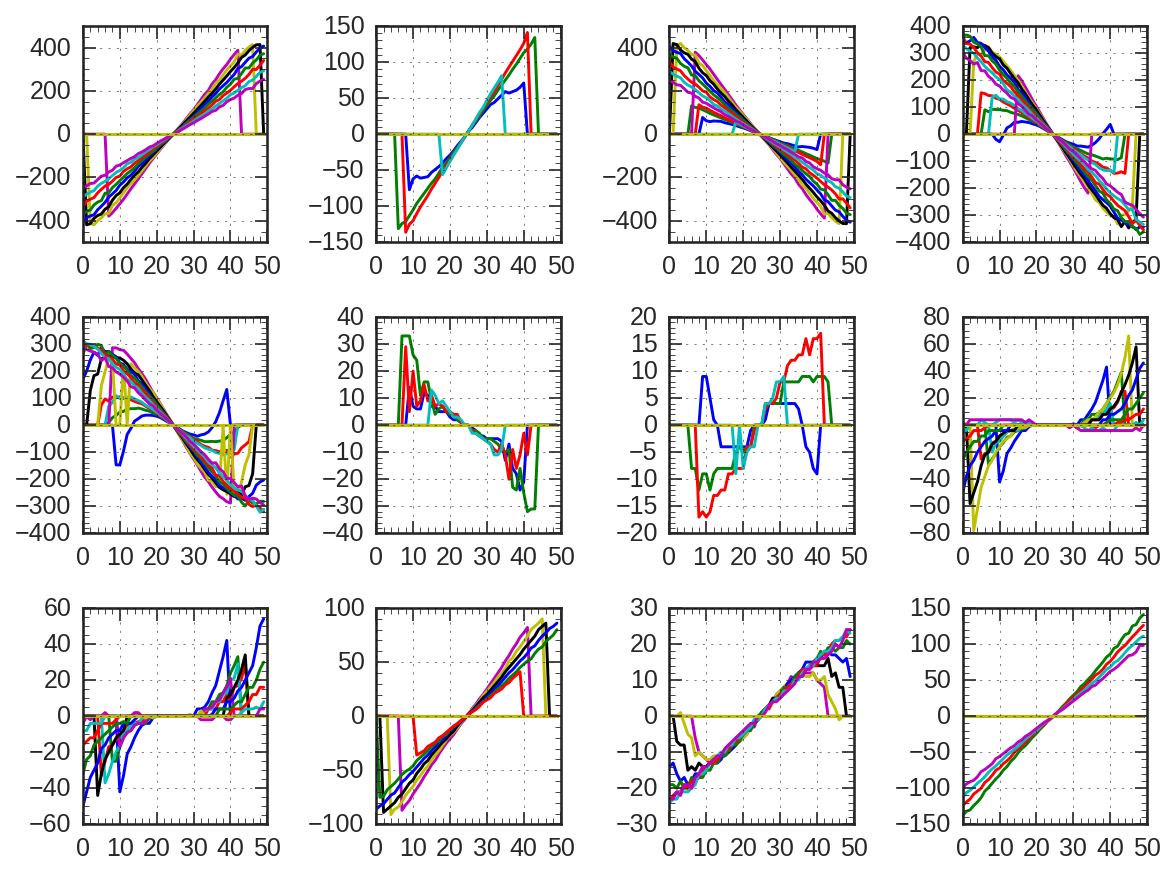

In [11]:
# Styling
plt.style.use('tdrstyle.mplstyle')

fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(8,6), tight_layout=True)

for i in xrange(nlayers):
  for j in xrange(13):
    axs[i/4,i%4].plot(np.arange(50), patterns_match_pre_1[:,j,i])
plt.show()

### Find pattern windows

In [13]:
%%time

_get_emtf_phi = lambda x: x[1]

patterns_phi = np.empty((len(pt_bins)-1, len(eta_bins)-1, nlayers), dtype=np.object)
patterns_match = np.empty((len(pt_bins)-1, len(eta_bins)-1, nlayers), dtype=np.object)  # used for matching
for ind in np.ndindex(patterns_phi.shape):
  patterns_phi[ind] = []
  patterns_match[ind] = []

# Loop over part and hits
for part, hits in zip(out_part, out_hits):
  (ipt, ieta, ipt50, ieta13, zone, mode) = part
  
  amap = {}  # emtf_layer -> hits
  
  for ihit, hit in enumerate(hits):
    if hit[0] != -99:
      amap.setdefault(hit[0], []).append(hit)
      
  for k, v in amap.iteritems():
    n = len(v)
    amap[k] = v[np.random.randint(n)]  # pick a random hit for each emtf_layer

  # Find hit phi at the key station
  key_hit_phi = None
  if 2 in amap:    # use ME2
    key_hit_phi = _get_emtf_phi(amap[2])
  elif 3 in amap:  # alternatively, use ME3
    key_hit_phi = _get_emtf_phi(amap[3])
    key_hit_phi -= patterns_match_pre_1[ipt50, ieta13, 3]
    key_hit_phi += patterns_match_pre_1[ipt50, ieta13, 2]
  elif 4 in amap:  # alternatively, use ME4
    key_hit_phi = _get_emtf_phi(amap[4])
    key_hit_phi -= patterns_match_pre_1[ipt50, ieta13, 4]
    key_hit_phi += patterns_match_pre_1[ipt50, ieta13, 2]

  if key_hit_phi is None:
    continue
    
  #lut = np.array([2, 2, 0, 0, 0, 0, 2, 3, 4, 0, 2, 0], dtype=np.int32)
  #lut = find_emtf_layer_partner.lut
  
  # Make pair of hits
  for k, v in amap.iteritems():
    emtf_layer = k
    hit_phi1 = _get_emtf_phi(v)
    patterns_phi[ipt, zone, emtf_layer].append(hit_phi1 - key_hit_phi)
    
    emtf_layer_partner = find_emtf_layer_partner(emtf_layer, zone)
    
    if emtf_layer_partner in amap:
      hit_phi2 = _get_emtf_phi(amap[emtf_layer_partner])
      patterns_match[ipt, zone, emtf_layer].append(hit_phi1 - hit_phi2)
  continue  # end loop over part and hits

CPU times: user 2min 58s, sys: 3.44 s, total: 3min 1s
Wall time: 2min 56s


In [24]:
valid_layers = np.zeros(patterns_phi.shape, dtype=np.bool)
valid_layers[:, 0, [0,2,3,4,7,8,10,11]]   = True
valid_layers[:, 1, [0,2,3,4,7,8,9,10,11]] = True
valid_layers[:, 2, [0,2,3,4,7,8,9,10]]    = True
valid_layers[:, 3, [0,2,3,4,7,8,9,10]]    = True
valid_layers[:, 4, [0,1,2,3,4,7,8,9,10]]  = True
valid_layers[:, 5, [1,2,3,4,5,6,7,8]]     = True

patterns_phi_1 = np.zeros(patterns_phi.shape + (63,), dtype=np.int32)  # make 63 bins, bin 31 is the highest pT
for ind in np.ndindex(patterns_phi.shape):
  if valid_layers[ind]:
    #print ind, np.percentile(patterns_phi[ind], [5,50,95], overwrite_input=True)
    patterns_phi_1[ind], _ = np.histogram(patterns_phi[ind], bins=63, range=(-0.5*63*superstrip_size,0.5*63*superstrip_size,))

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0-omkpbe5/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


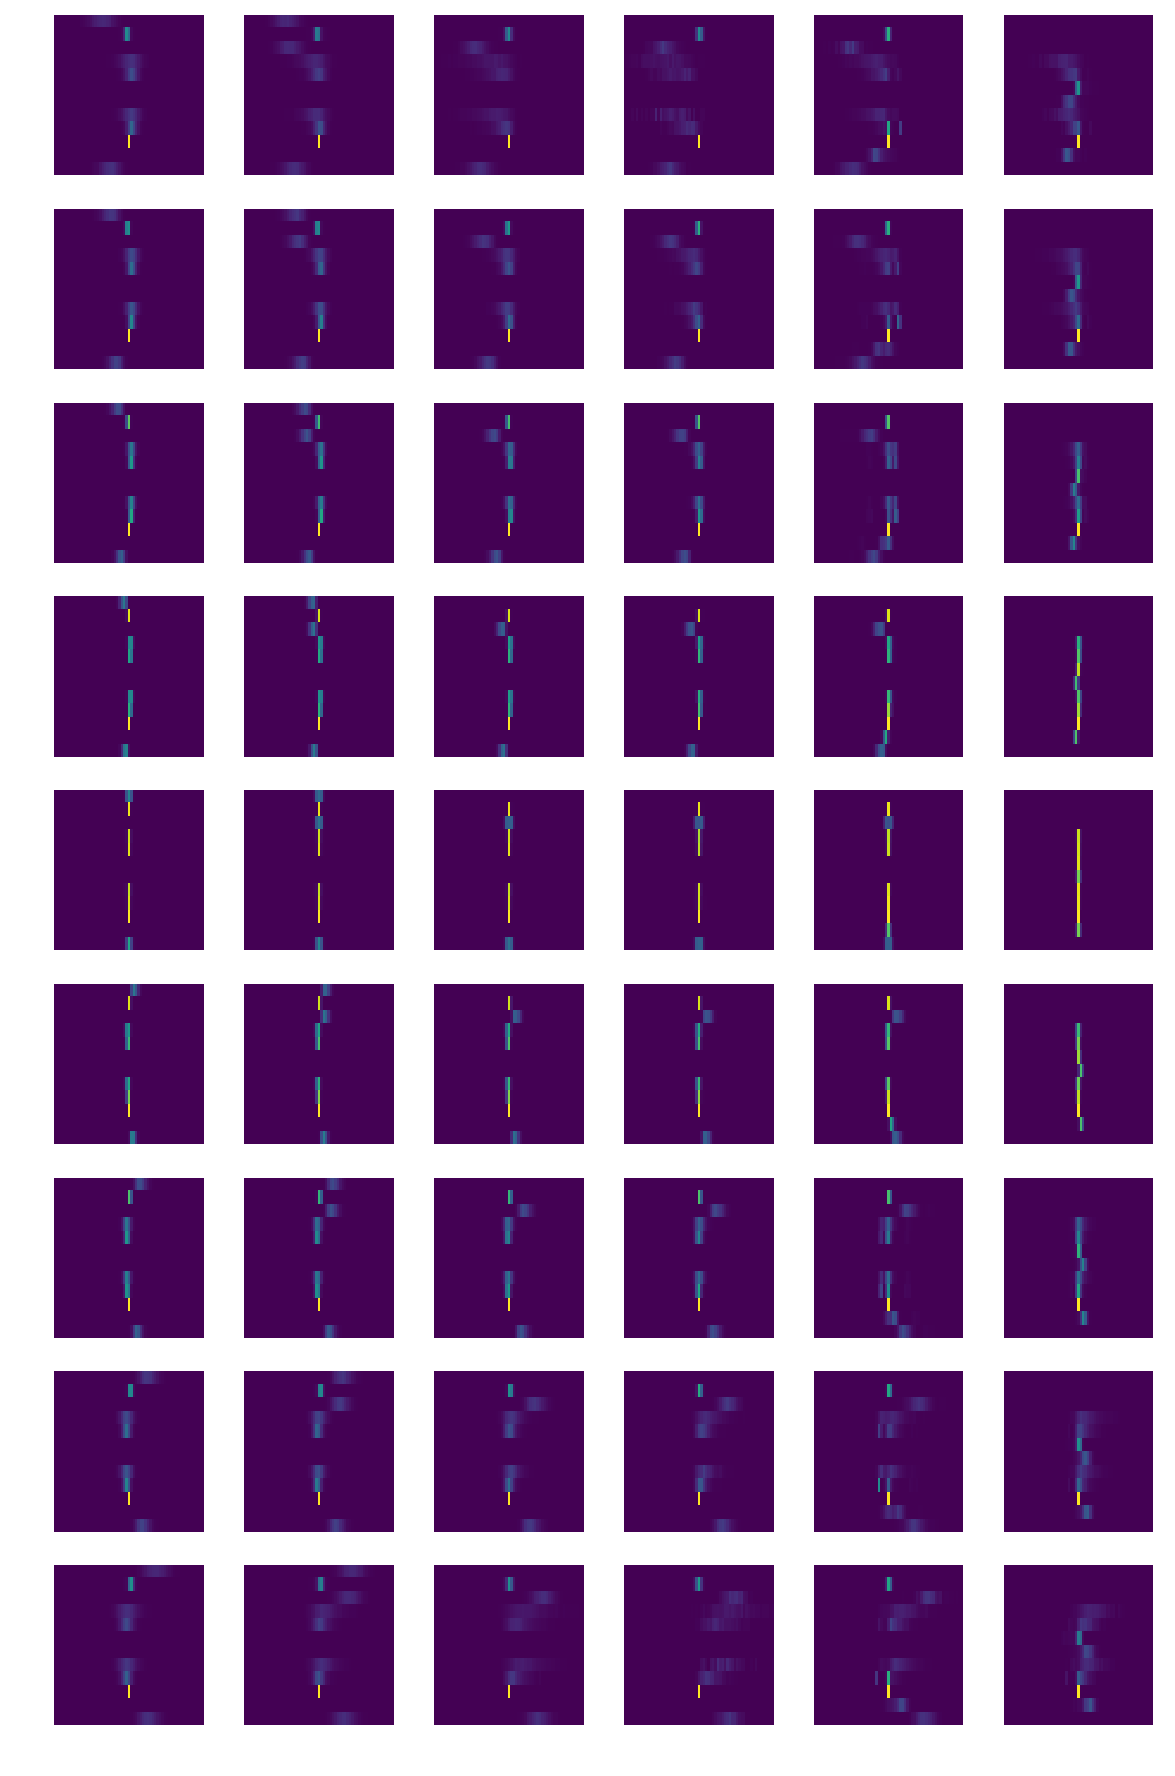

In [25]:
fig, axs = plt.subplots(ncols=6, nrows=9, figsize=(8,8./6*9), tight_layout=True, sharex=True, sharey=True)

for i in xrange(9):
  for j in xrange(6):
    norm = patterns_phi_1[i,j,:].sum(axis=1)
    img = np.true_divide(patterns_phi_1[i,j,:], norm[:,np.newaxis])
    img[np.isnan(img)] = 0
    
    axs[i,j].imshow(img, origin='lower', interpolation='nearest', aspect='auto')
    axs[i,j].axis('off')
    
plt.show()

In [26]:
patterns_phi_2 = np.zeros(patterns_phi.shape + (3,), dtype=np.int32)
for ind in np.ndindex(patterns_phi.shape):
  if valid_layers[ind]:
    #print ind, np.percentile(patterns_phi[ind], [5,50,95], overwrite_input=True)
    
    x = patterns_phi_1[ind].copy()
    norm = x.sum()
    x = np.true_divide(x, norm)
    x[np.isnan(x)] = 0
    
    try:
      y = np.where(x > 0.01)[0]
      y = y[0] - 31, y[-1] - 31  # offset by 31
    except:
      y = 0, 0
    
    z = np.percentile(patterns_phi[ind], [2.5,50,97.5], overwrite_input=True)
    z = np.round(np.true_divide(z, superstrip_size))
    print ind, y, z
    
    patterns_phi_2[ind] = y[0], z[1], y[1]

(0, 0, 0) (-15, -2) [-14.  -8.  -3.]
(0, 0, 2) (0, 0) [0. 0. 0.]
(0, 0, 3) (-2, 5) [-2.  1.  4.]
(0, 0, 4) (-5, 7) [-5.  1.  6.]
(0, 0, 7) (-3, 5) [-3.  1.  5.]
(0, 0, 8) (-6, 7) [-7.  1.  7.]
(0, 0, 10) (-3, 1) [-2. -1.  1.]
(0, 0, 11) (-19, -4) [-19. -11.  -4.]
(0, 1, 0) (-18, -4) [-18. -10.  -4.]
(0, 1, 2) (0, 0) [0. 0. 0.]
(0, 1, 3) (-5, 4) [-5.  0.  3.]
(0, 1, 4) (-10, 5) [-12.  -2.   4.]
(0, 1, 7) (-7, 4) [-8. -0.  4.]
(0, 1, 8) (-13, 5) [-15.  -2.   5.]
(0, 1, 9) (-19, -5) [-20. -13.  -6.]
(0, 1, 10) (-3, 2) [-3. -1.  2.]
(0, 1, 11) (-21, -7) [-21. -14.  -7.]
(0, 2, 0) (-20, -5) [-20. -12.  -6.]
(0, 2, 2) (0, 0) [0. 0. 0.]
(0, 2, 3) (-13, 3) [-12.  -2.   2.]
(0, 2, 4) (-20, 2) [-23.  -6.   2.]
(0, 2, 7) (-16, 3) [-16.  -4.   2.]
(0, 2, 8) (-22, 2) [-28.  -8.   2.]
(0, 2, 9) (-21, -7) [-21. -14.  -8.]
(0, 2, 10) (-2, 2) [-2. -0.  2.]
(0, 3, 0) (-19, -6) [-19. -12.  -6.]
(0, 3, 2) (0, 0) [0. 0. 0.]
(0, 3, 3) (-16, 1) [-15.  -5.   0.]
(0, 3, 4) (-28, 2) [-25. -11.  -2.]
(0, 3, 7) (

(5, 2, 0) (1, 5) [1. 2. 5.]
(5, 2, 2) (0, 0) [0. 0. 0.]
(5, 2, 3) (-1, 1) [-1. -0.  0.]
(5, 2, 4) (-2, 1) [-2. -0.  1.]
(5, 2, 7) (-1, 1) [-1. -0.  0.]
(5, 2, 8) (-2, 1) [-2. -0.  1.]
(5, 2, 9) (1, 6) [1. 3. 6.]
(5, 2, 10) (0, 1) [-0.  0.  1.]
(5, 3, 0) (1, 6) [1. 3. 5.]
(5, 3, 2) (0, 0) [0. 0. 0.]
(5, 3, 3) (-1, 1) [-1. -0.  0.]
(5, 3, 4) (-1, 1) [-1. -0.  1.]
(5, 3, 7) (-1, 1) [-1. -0.  1.]
(5, 3, 8) (-2, 1) [-2. -0.  1.]
(5, 3, 9) (1, 7) [2. 4. 6.]
(5, 3, 10) (0, 1) [-0.  0.  1.]
(5, 4, 0) (1, 6) [1. 3. 6.]
(5, 4, 1) (0, 3) [0. 1. 3.]
(5, 4, 2) (0, 0) [0. 0. 0.]
(5, 4, 3) (-1, 0) [-1. -0.  0.]
(5, 4, 4) (-1, 1) [-1. -0.  0.]
(5, 4, 7) (-1, 1) [-1. -0.  0.]
(5, 4, 8) (-1, 1) [-1. -0.  1.]
(5, 4, 9) (2, 7) [2. 4. 7.]
(5, 4, 10) (0, 1) [-0.  0.  1.]
(5, 5, 1) (0, 2) [0. 1. 2.]
(5, 5, 2) (0, 0) [0. 0. 0.]
(5, 5, 3) (-1, 1) [-1. -0.  0.]
(5, 5, 4) (-1, 1) [-1. -0.  1.]
(5, 5, 5) (0, 2) [0. 1. 2.]
(5, 5, 6) (0, 1) [-0.  0.  1.]
(5, 5, 7) (-1, 1) [-1. -0.  1.]
(5, 5, 8) (-1, 1) [-1. -0.  1

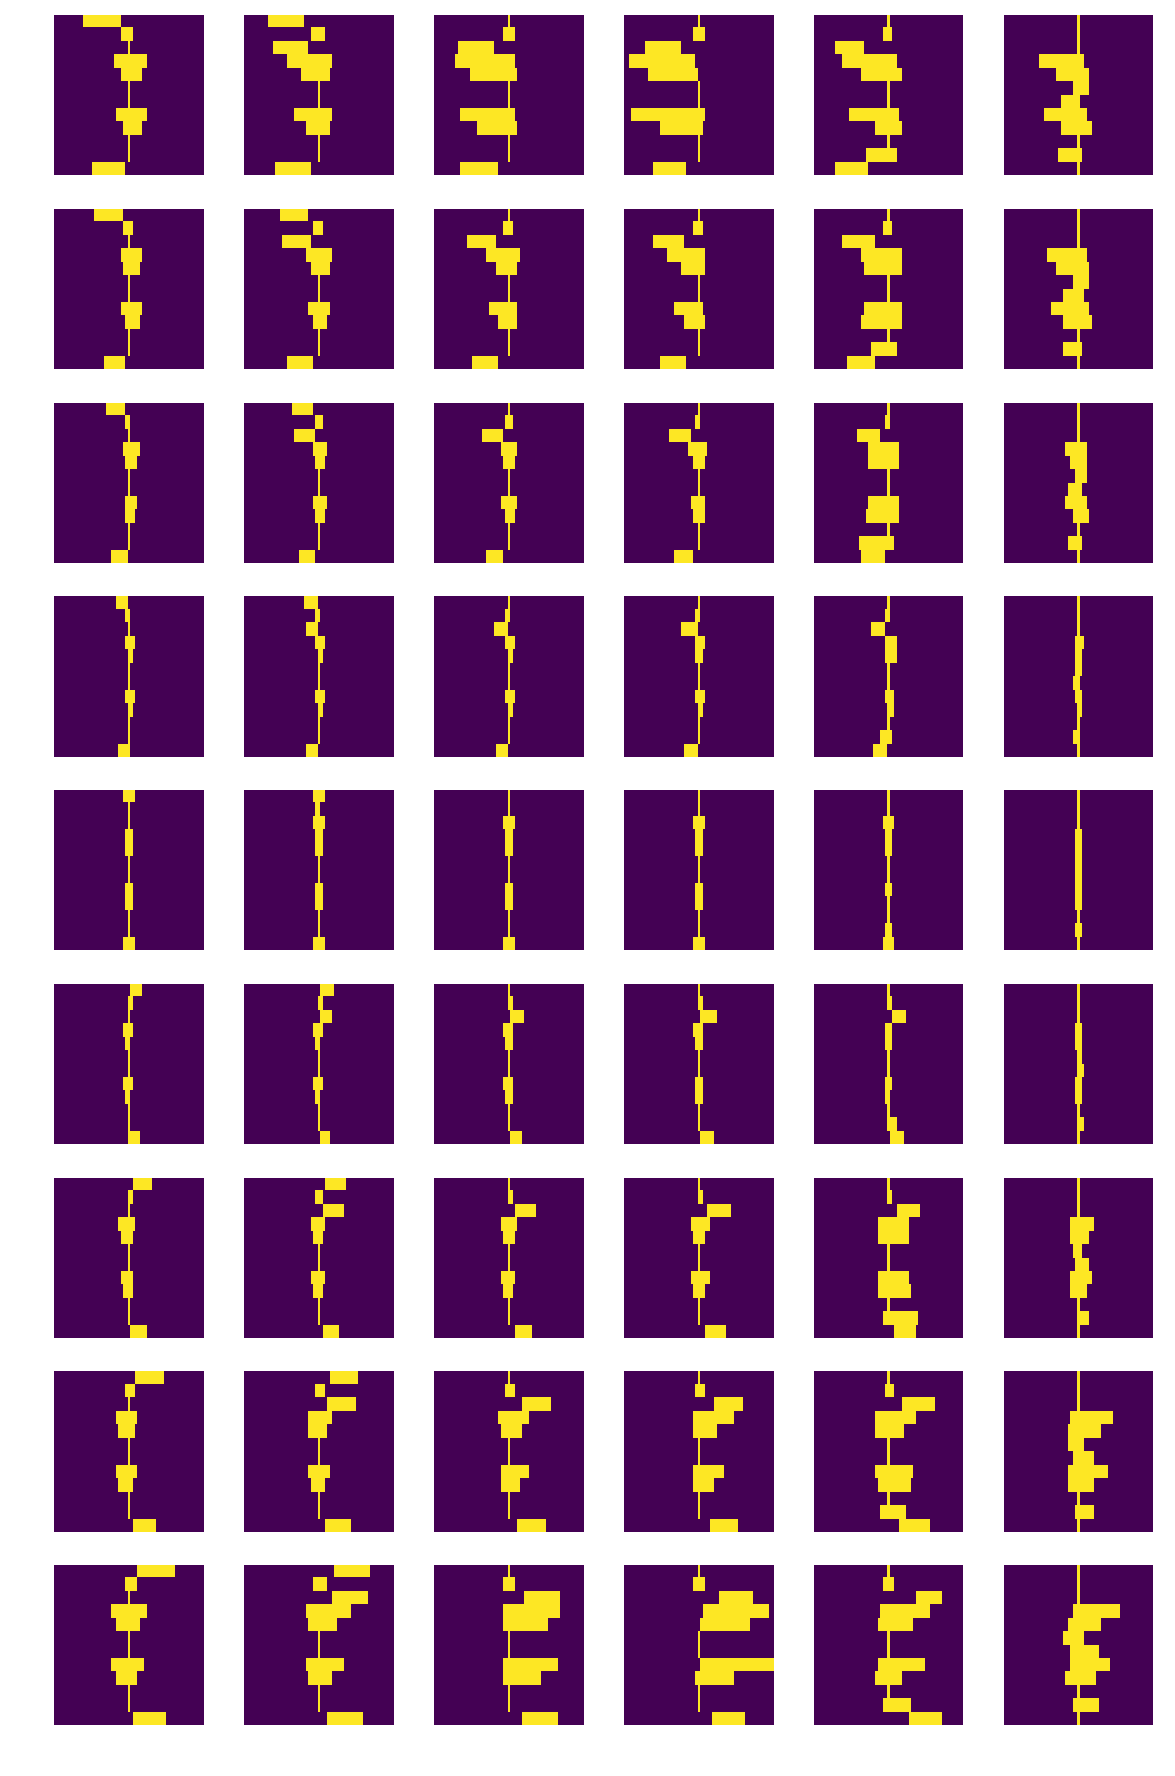

In [27]:
fig, axs = plt.subplots(ncols=6, nrows=9, figsize=(8,8./6*9), tight_layout=True, sharex=True, sharey=True)

for i in xrange(9):
  for j in xrange(6):
    
    img = np.zeros((nlayers, 63), dtype=np.float32)
    for k in xrange(nlayers):
      x0, x1 = patterns_phi_2[i,j,k,0] + 31, patterns_phi_2[i,j,k,2] + 31  # offset by 31
      img[k, slice(x0,x1+1)] = 1

    axs[i,j].imshow(img, origin='lower', interpolation='nearest', aspect='auto')
    axs[i,j].axis('off')
    
plt.show()

In [28]:
patterns_match_1 = np.zeros(patterns_match.shape + (3,), dtype=np.int32)  # used for matching

for ind in np.ndindex(patterns_match.shape):
  if valid_layers[ind]:
    patterns_match_1[ind] = np.percentile(patterns_match[ind], [5, 50, 95], overwrite_input=True)
    print ind, patterns_match_1[ind]

(0, 0, 0) [-418 -256 -117]
(0, 0, 2) [117 256 418]
(0, 0, 3) [ 93 292 514]
(0, 0, 4) [ 31 284 548]
(0, 0, 7) [-36   0  24]
(0, 0, 8) [-42  -4  18]
(0, 0, 10) [-60 -21   3]
(0, 0, 11) [-149  -99  -55]
(0, 1, 0) [-510 -336 -186]
(0, 1, 2) [186 336 510]
(0, 1, 3) [100 339 574]
(0, 1, 4) [-58 277 563]
(0, 1, 7) [-78 -16  12]
(0, 1, 8) [-82 -20   8]
(0, 1, 9) [-99 -70 -43]
(0, 1, 10) [-58 -18  13]
(0, 1, 11) [-167 -123  -78]
(0, 2, 0) [-569 -392 -229]
(0, 2, 2) [229 392 569]
(0, 2, 3) [  2 315 565]
(0, 2, 4) [-302  174  493]
(0, 2, 7) [-169  -48   -4]
(0, 2, 8) [-157  -46   -4]
(0, 2, 9) [-111  -84  -55]
(0, 2, 10) [-48  -7  37]
(0, 3, 0) [-577 -400 -239]
(0, 3, 2) [239 400 577]
(0, 3, 3) [-93 242 509]
(0, 3, 4) [-403   48  433]
(0, 3, 7) [-281 -102  -28]
(0, 3, 8) [-145  -52   -4]
(0, 3, 9) [-118  -92  -65]
(0, 3, 10) [-29   7  51]
(0, 4, 0) [-649 -483 -335]
(0, 4, 1) [-248 -178 -107]
(0, 4, 2) [335 483 649]
(0, 4, 3) [169 390 608]
(0, 4, 4) [-103  257  559]
(0, 4, 7) [-106  -37   -1]
(0, 

(8, 0, 10) [-3 21 59]
(8, 0, 11) [ 52  99 150]
(8, 1, 0) [186 337 510]
(8, 1, 2) [-510 -337 -186]
(8, 1, 3) [-572 -335 -102]
(8, 1, 4) [-564 -277   65]
(8, 1, 7) [-12  16  78]
(8, 1, 8) [-8 20 85]
(8, 1, 9) [41 70 99]
(8, 1, 10) [-12  19  58]
(8, 1, 11) [ 75 123 167]
(8, 2, 0) [234 392 573]
(8, 2, 2) [-573 -392 -234]
(8, 2, 3) [-557 -312   -7]
(8, 2, 4) [-500 -170  287]
(8, 2, 7) [  4  50 173]
(8, 2, 8) [  4  46 153]
(8, 2, 9) [ 56  84 111]
(8, 2, 10) [-37   7  49]
(8, 3, 0) [248 408 587]
(8, 3, 2) [-587 -408 -248]
(8, 3, 3) [-524 -265   43]
(8, 3, 4) [-353  -65  405]
(8, 3, 7) [ 26 106 277]
(8, 3, 8) [ 16  62 140]
(8, 3, 9) [ 68  94 118]
(8, 3, 10) [-45  -4  30]
(8, 4, 0) [345 488 636]
(8, 4, 1) [110 180 250]
(8, 4, 2) [-636 -488 -345]
(8, 4, 3) [-640 -406 -232]
(8, 4, 4) [-561 -254   94]
(8, 4, 7) [  4  37 114]
(8, 4, 8) [  5  49 134]
(8, 4, 9) [ 80 106 138]
(8, 4, 10) [-26   8  40]
(8, 5, 1) [ 74 150 221]
(8, 5, 2) [-221 -150  -74]
(8, 5, 3) [-241 -101   86]
(8, 5, 4) [-179   11  30

In [29]:
outfile = 'histos_tb.npz'
np.savez_compressed(outfile, patterns_phi=patterns_phi_2, patterns_match=patterns_match_1)

In [30]:
loaded = np.load('histos_tb.npz')
print loaded['patterns_phi'].shape
print loaded['patterns_match'].shape

(9, 6, 12, 3)
(9, 6, 12, 3)
